## Pfam seed random split

In [1]:
#ONLY RUN IF USING TORCH

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
torch.cuda.empty_cache() 

In [20]:
#ONLY RUN IF USING TORCH

from tape import ProteinBertModel, TAPETokenizer
model = ProteinBertModel.from_pretrained('bert-base')
modelTAPE = model.to(device)
tokenizerTAPE = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model

modelTAPE.half()  # convert to half precision
for layer in modelTAPE.modules():
    if isinstance(layer, torch.nn.BatchNorm2d):
        layer.float()

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc
import sklearn
import pickle

In [2]:
def parse_fasta (lines):
    descs = []
    seqs = []
    data = ''
    for line in lines:
        if line.startswith('>'):
            if data:   # have collected a sequence, push to seqs
                seqs.append(data)
                data = ''
            descs.append(line[1:])  # Trim '>' from beginning
        else:
            data += line.rstrip('\r\n')
    # there will be yet one more to push when we run out
    seqs.append(data)
    return descs, seqs

In [3]:
def get_performance_vals(preds, classes):
    #0 is negative, 1 is positive
    a = np.array(preds) #Predictions
    b = classes #actual outcomes / classes
    #print("Predicted and actual classes\n")
    #print(classes)
    #print(a)
    tp = np.sum(np.multiply(a==1, b==1)) #TP
    fp = np.sum(np.multiply(a==1, b==0)) #FP
    tn = np.sum(np.multiply(a==0, b==0)) #TN
    fn = np.sum(np.multiply(a==0, b==1)) #FN

    tp = int(tp)
    fp = int(fp)
    tn = int(tn)
    fn = int(fn)

    print("True positive: %d, false positive: %d, true negative: %d, false negative: %d\n" %(tp,fp,tn,fn))

    mcc = (tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fscore = 2*precision*recall/(precision+recall)
    accuracy = np.sum(a==b)/len(classes)

    print("%s: %2f" % ('MCC', mcc))
    print("%s: %.2f%%" % ('Accuracy', 100*accuracy))
    print("%s: %.2f" % ('F1 score', fscore))
    print("%s: %.2f" % ('Precision', precision))
    print("%s: %.2f" % ('Recall', recall))

    #return mcc, precision, recall, fscore, accuracy

In [4]:
path = "./" + "pos_seqs_reduced" + ".pickle"
array_file = open(path, 'rb')
pos = pickle.load(array_file)
array_file.close()

len(pos)

2914

In [5]:
path = "./" + "pos_labels_reduced" + ".pickle"
array_file = open(path, 'rb')
pos_labels = pickle.load(array_file)
array_file.close()
len(pos_labels)

2914

In [6]:
handle = open("./cullpdb.fasta", 'r')
descs, neg = parse_fasta(handle.read().split('\n'))

In [7]:
pdb = [d[:4] for d in descs]

In [8]:
dirpath = '../StructuralDataCreating/structures'
filist = os.listdir(dirpath)
flist = [s for s in filist if s.startswith('PDBpos') == True]
pos_pdbs = []
for f in flist:
    handle = open(os.path.join(dirpath, f), 'r')
    lines = handle.readlines()
    for line in lines:
        pos_pdbs.append(line.strip().split(' ')[0])

In [9]:
idx = []
name = []
i = 0
for p in pdb:
    if p in pos_pdbs:
        idx.append(i)
        name.append(p)
    i = i + 1

In [10]:
print(idx)
print(name)

[1943, 2350, 3201, 3310]
['6MYI', '1PP0', '4WDC', '3WZ3']


In [11]:
idx.reverse()

In [12]:
len(neg)

3684

In [13]:
print(idx)
for ix in idx:
    neg.pop(ix)

[3310, 3201, 2350, 1943]


In [14]:
neg_size = len(neg)
neg_size

3680

In [15]:
neg_labels = ['negative']*neg_size
len(neg_labels)

3680

In [16]:
data = pos + neg
labels = pos_labels + neg_labels

from sklearn.model_selection import train_test_split
train, dev, train_labels, validation_labels = train_test_split(
    data,
    labels,
    test_size = 0.2,
    random_state=1,
    stratify=labels)

#can jump to Method 3 from here

In [20]:
from collections import Counter

print(Counter(train_labels))
print(Counter(validation_labels))

Counter({'negative': 2944, 'pos_PF01823_rp15_MACPF_659.txt': 371, 'pos_PF03318_full_ETX_MTX2_440.txt': 229, 'pos_PF12261_full_T_hemolysin_327.txt': 227, 'PF01289_full_Thiol_cytolysin_243.txt': 147, 'pos_PF06369_full_anemone_cytotox_363.txt': 133, 'pos_PF06355_full_Aegerolysin_308.txt': 133, 'pos_PF11393_full_T4BSS_DotI_IcmL_214.txt': 125, 'pos_PF03945_full_Endotoxin_N_180.txt': 101, 'pos_PF05105_seed_Phage_holin_4_1_131.txt': 94, 'pos_PF01117_full_Aerolysin_207.txt': 93, 'PF00087_full_Toxin_TOLIP_333.txt': 81, 'PF07367_full_FB_lectin_171.txt': 78, 'pos_PF03944_seed_Endotoxin_C_80.txt': 59, 'pos_PF01338_full_Bac_thur_toxin_87.txt': 50, 'pos_PF05802_full_EspB_60.txt': 45, 'pos_PF18063_full_BB_PF_52.txt': 39, 'pos_PF07968_full_Leukocidin_89.txt': 38, 'pos_PF06109_full_HlyE_62.txt': 37, 'PF04598_rp15_Gasdermin_62.txt': 35, 'pos_PF04877_full_Harpin_35.txt': 26, 'pos_PF12920_full_TcdA_TcdB_pore_46.txt': 26, 'pos_PF00555_seed_Endotoxin_M_36.txt': 26, 'PF11565_full_porB_30.txt': 23, 'pos_PF010

## Loading the data

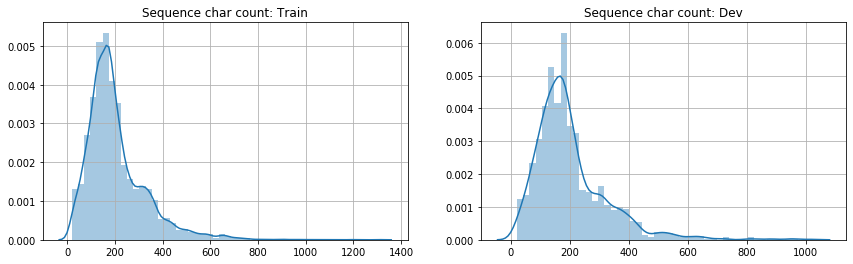

In [21]:
# Length of sequence in train data.
trainlen= [len(x) for x in train]
devlen= [len(x) for x in dev]

def plot_seq_count(lengths, data_name):
    seaborn.distplot(lengths)
    plt.title(f'Sequence char count: {data_name}')
    plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(trainlen, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(devlen, 'Dev')

plt.subplots_adjust(right=3.0)
plt.show()

In [22]:
print(max(trainlen))
print(max(devlen))

1305
1015


In [23]:
vocab_size = 21
max_length = 800
trunc_type = "post"
padding_type = "post"

trainTAPE = [tokenizerTAPE.encode(w.upper()) for w in train]
valTAPE = [tokenizerTAPE.encode(w.upper()) for w in dev]

In [24]:
trainTAPE = [np.array(t[:max_length]) for t in trainTAPE]
valTAPE = [np.array(t[:max_length]) for t in valTAPE]

trainTAPE = [torch.from_numpy(t) for t in trainTAPE]
valTAPE = [torch.from_numpy(t) for t in valTAPE]

In [25]:
TAPEtrain = torch.nn.utils.rnn.pad_sequence(trainTAPE, batch_first=False)
TAPEvalidation = torch.nn.utils.rnn.pad_sequence(valTAPE, batch_first=False)

In [26]:
TAPEtrain = torch.transpose(TAPEtrain,0,1)
TAPEvalidation = torch.transpose(TAPEvalidation,0,1)

In [27]:
TAPEtrain.size()

torch.Size([5275, 800])

In [28]:
TAPEvalidation.size()

torch.Size([1319, 800])

In [29]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
batch_size = 1

dataloader_train = DataLoader(
    TAPEtrain,
    batch_size=batch_size
)

dataloader_validation = DataLoader(
    TAPEvalidation,
    batch_size=batch_size
)

In [30]:
del pos, neg, data, labels, neg_labels, pos_labels, trainTAPE, valTAPE, TAPEtrain, TAPEvalidation
gc.collect()

12079

In [31]:
torch.cuda.empty_cache() 

In [32]:
TAPEncoded_train = []
#iternum = 0
with torch.no_grad():
    for batch in tqdm(dataloader_train):
        b = batch.to(torch.long)
        output = modelTAPE(b.to(device))[1]
        TAPEncoded_train.append(output.cpu().detach().numpy())
#         if iternum%100 == 0:
#             print(iternum)
#         iternum = iternum + 1

In [33]:
TAPEncoded_val = []
#iternum = 0
for batch in tqdm(dataloader_validation):
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[1]
    TAPEncoded_val.append(output.cpu().detach().numpy())
#     if iternum%100 == 0:
#         print(iternum)
#     iternum = iternum + 1

In [34]:
path = "./" + "TAPEncoded_train_pooled" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_train, output)
output.close()

path = "./" + "TAPEncoded_val_pooled" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_val, output)
output.close()

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
validation_labels = le.transform(validation_labels)
#test_labels = le.transform(test_labels)

train_labels.shape, validation_labels.shape

((5275,), (1319,))

In [36]:
path = "./" + "train_labels" + ".pickle"
output = open(path, 'w+b')
pickle.dump(train_labels, output)
output.close()

path = "./" + "validation_labels" + ".pickle"
output = open(path, 'w+b')
pickle.dump(validation_labels, output)
output.close()

In [37]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
umap_map = {v: k for k, v in le_name_mapping.items()}
print(umap_map)

{0: 'PF00087_full_Toxin_TOLIP_333.txt', 1: 'PF01289_full_Thiol_cytolysin_243.txt', 2: 'PF02382_full_RTX_14.txt', 3: 'PF04598_rp15_Gasdermin_62.txt', 4: 'PF07367_full_FB_lectin_171.txt', 5: 'PF11565_full_porB_30.txt', 6: 'negative', 7: 'pos_PF00555_seed_Endotoxin_M_36.txt', 8: 'pos_PF01024_full_Colicin_26.txt', 9: 'pos_PF01117_full_Aerolysin_207.txt', 10: 'pos_PF01338_full_Bac_thur_toxin_87.txt', 11: 'pos_PF01823_rp15_MACPF_659.txt', 12: 'pos_PF03318_full_ETX_MTX2_440.txt', 13: 'pos_PF03505_full_Clenterotox_9.txt', 14: 'pos_PF03944_seed_Endotoxin_C_80.txt', 15: 'pos_PF03945_full_Endotoxin_N_180.txt', 16: 'pos_PF04877_full_Harpin_35.txt', 17: 'pos_PF05105_seed_Phage_holin_4_1_131.txt', 18: 'pos_PF05802_full_EspB_60.txt', 19: 'pos_PF06109_full_HlyE_62.txt', 20: 'pos_PF06355_full_Aegerolysin_308.txt', 21: 'pos_PF06369_full_anemone_cytotox_363.txt', 22: 'pos_PF07968_full_Leukocidin_89.txt', 23: 'pos_PF11393_full_T4BSS_DotI_IcmL_214.txt', 24: 'pos_PF12261_full_T_hemolysin_327.txt', 25: 'pos_

In [38]:
del TAPEncoded_train, TAPEncoded_val
gc.collect()
torch.cuda.empty_cache() 

#now getting the full embedding for all amino acid, not the pooled one
TAPEncoded_train = []
#iternum = 0
for batch in tqdm(dataloader_train):
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[0]
    TAPEncoded_train.append(output.cpu().detach().numpy())
#     if iternum%100 == 0:
#         print(iternum)
#     iternum = iternum + 1

In [39]:
TAPEncoded_val = []
#iternum = 0
for batch in tqdm(dataloader_validation):
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[0]
    TAPEncoded_val.append(output.cpu().detach().numpy())
#     if iternum%100 == 0:
#         print(iternum)
#     iternum = iternum + 1

In [40]:
path = "./" + "TAPEncoded_train" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_train, output)
output.close()

path = "./" + "TAPEncoded_val" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_val, output)
output.close()

In [ ]:
#Method0 - Baseline, first nearest neighbour in terms of Levenshtein distance

In [25]:
path = "./" + "train_labels" + ".pickle"
array_file = open(path, 'rb')
train_labels = pickle.load(array_file)
array_file.close()

path = "./" + "validation_labels" + ".pickle"
array_file = open(path, 'rb')
validation_labels = pickle.load(array_file)
array_file.close()

In [41]:
print(len(train))
print(len(dev))
print(len(train_labels))
print(len(validation_labels))

5275
1319
5275
1319


In [42]:
mask = (validation_labels == 6) #6 is negative

y_true = validation_labels
y_true[~mask] = 1
y_true[mask] = 0

In [43]:
validation_labels

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [44]:
mask = (train_labels == 6) #6 is negative

y_true = train_labels
y_true[~mask] = 1
y_true[mask] = 0

In [45]:
train_labels

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [46]:
import Levenshtein
from tqdm import tqdm

dist_arr = np.ones([len(dev), len(train)])*500

for i in tqdm(range(len(dev))):
    for j in range(len(train)):
        dist_arr[i,j] = Levenshtein.distance(dev[i], train[j])

100%|██████████████████████████████████████████████████████████████████████████████| 1319/1319 [06:24<00:00,  3.43it/s]


In [47]:
np.amin(dist_arr, 1)

array([211., 173.,  85., ..., 103.,  74., 283.])

In [48]:
np.argmin(dist_arr, 1)

array([4692, 4774,  707, ..., 2456, 3254, 1554], dtype=int64)

In [49]:
preds = train_labels[np.argmin(dist_arr, 1)]

In [50]:
get_performance_vals(preds, validation_labels)

True positive: 559, false positive: 169, true negative: 567, false negative: 24

MCC: 0.728230
Accuracy: 85.37%
F1 score: 0.85
Precision: 0.77
Recall: 0.96


In [ ]:
#METHOD 1

In [ ]:
#STARTING HERE

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# import tensorflow.keras.backend as K
# dtype = 'float16'
# K.set_floatx(dtype)
# K.set_epsilon(1e-4)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Tensorflow version 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

True
Compute dtype: float16
Variable dtype: float32


In [2]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc
import sklearn
import pickle

In [3]:
path = "./" + "TAPEncoded_train_pooled" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_train = pickle.load(array_file)
array_file.close()

path = "./" + "TAPEncoded_val_pooled" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_val = pickle.load(array_file)
array_file.close()

path = "./" + "train_labels" + ".pickle"
array_file = open(path, 'rb')
train_labels = pickle.load(array_file)
array_file.close()

path = "./" + "validation_labels" + ".pickle"
array_file = open(path, 'rb')
validation_labels = pickle.load(array_file)
array_file.close()

In [4]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-5 * 10**(epoch / 20))

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=5)

In [5]:
numclass = max(train_labels) + 1

In [6]:
input_x = tf.keras.layers.Input(shape=768) #768 is the embedding dimension
out = tf.keras.layers.Dense(numclass, activation="softmax")(input_x) 
model = tf.keras.Model(inputs=input_x, outputs=out)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 30)                23070     
Total params: 23,070
Trainable params: 23,070
Non-trainable params: 0
_________________________________________________________________


In [7]:
TAPEncoded_train = np.array(TAPEncoded_train)

In [8]:
TAPEncoded_train = TAPEncoded_train.reshape(-1,768)

In [9]:
TAPEncoded_val = np.array(TAPEncoded_val)

In [10]:
TAPEncoded_val = TAPEncoded_val.reshape(-1,768)

In [11]:
history = model.fit(TAPEncoded_train, train_labels, epochs=100, validation_data=(TAPEncoded_val, validation_labels), verbose=2, callbacks=[es])

Epoch 1/100
165/165 - 0s - loss: 1.8831 - accuracy: 0.5471 - val_loss: 1.6955 - val_accuracy: 0.5580
Epoch 2/100
165/165 - 0s - loss: 1.5966 - accuracy: 0.5617 - val_loss: 1.4947 - val_accuracy: 0.5701
Epoch 3/100
165/165 - 0s - loss: 1.4519 - accuracy: 0.5782 - val_loss: 1.3796 - val_accuracy: 0.6194
Epoch 4/100
165/165 - 0s - loss: 1.3569 - accuracy: 0.5994 - val_loss: 1.3045 - val_accuracy: 0.6224
Epoch 5/100
165/165 - 0s - loss: 1.2727 - accuracy: 0.6254 - val_loss: 1.2460 - val_accuracy: 0.6452
Epoch 6/100
165/165 - 0s - loss: 1.2128 - accuracy: 0.6411 - val_loss: 1.1744 - val_accuracy: 0.6558
Epoch 7/100
165/165 - 0s - loss: 1.1626 - accuracy: 0.6595 - val_loss: 1.1163 - val_accuracy: 0.6588
Epoch 8/100
165/165 - 0s - loss: 1.1148 - accuracy: 0.6669 - val_loss: 1.0864 - val_accuracy: 0.6945
Epoch 9/100
165/165 - 0s - loss: 1.0827 - accuracy: 0.6794 - val_loss: 1.0412 - val_accuracy: 0.6983
Epoch 10/100
165/165 - 0s - loss: 1.0497 - accuracy: 0.6900 - val_loss: 1.0262 - val_accura

In [12]:
preds = model.predict(TAPEncoded_val)

mask = (validation_labels == 6) #6 is negative

predictions = np.argmax(preds, axis=1)

y_true = validation_labels
y_true[~mask] = 1
y_true[mask] = 0

mask = (predictions == 6)
y_pred = predictions
y_pred[~mask] = 1
y_pred[mask] = 0

In [15]:
get_performance_vals(y_pred, y_true)

True positive: 447, false positive: 80, true negative: 656, false negative: 136

MCC: 0.667190
Accuracy: 83.62%
F1 score: 0.81
Precision: 0.85
Recall: 0.77


In [1]:
#METHOD 2

In [2]:
#STARTING HERE

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# import tensorflow.keras.backend as K
# dtype = 'float16'
# K.set_floatx(dtype)
# K.set_epsilon(1e-4)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Tensorflow version 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

True
Compute dtype: float16
Variable dtype: float32


In [4]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc
import sklearn
import pickle

In [5]:
path = "./" + "TAPEncoded_train" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_train = pickle.load(array_file)
array_file.close()

path = "./" + "TAPEncoded_val" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_val = pickle.load(array_file)
array_file.close()

path = "./" + "train_labels" + ".pickle"
array_file = open(path, 'rb')
train_labels = pickle.load(array_file)
array_file.close()

path = "./" + "validation_labels" + ".pickle"
array_file = open(path, 'rb')
validation_labels = pickle.load(array_file)
array_file.close()

TAPEncoded_train = np.array(TAPEncoded_train)
TAPEncoded_train = np.squeeze(TAPEncoded_train)

TAPEncoded_val = np.array(TAPEncoded_val)
TAPEncoded_val = np.squeeze(TAPEncoded_val)

numclass = max(train_labels) + 1

In [6]:
def residual_block(x, filters, dil):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, 3, dilation_rate = dil, padding="same")(a1) #1100 filters and 9 kernel size in ProtCNN
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, 1, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    
    return x

In [7]:
# batch_size = 8
# n_timesteps = 400
# n_features = 768
# input_x = tf.keras.layers.Input(shape=(n_timesteps,n_features))
# bi_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, batch_input_shape=(batch_size, n_timesteps, n_features), 
#                                                             kernel_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             recurrent_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             bias_regularizer=tf.keras.regularizers.l2(0.01)))(input_x)
# out = tf.keras.layers.Dense(49, activation="softmax")(bi_rnn) 
# model = tf.keras.Model(inputs=input_x, outputs=out)
# model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
# model.summary()

input_x = tf.keras.layers.Input(shape=(800,768))
x = tf.keras.layers.Conv1D(128, 3, padding="same")(input_x)
x = residual_block(x, 128, 1)
#x = tf.keras.layers.Dropout(0.3)(x)
x = residual_block(x, 128, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(800)(x)

x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(numclass, activation="softmax")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 768)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 128)     295040      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 800, 128)     512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 800, 128)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-5 * 10**(epoch / 20))

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=5)

In [9]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    
reset_random_seeds()

In [10]:
history = model.fit(TAPEncoded_train, train_labels, epochs=25, validation_data=(TAPEncoded_val, validation_labels), verbose=2, callbacks=[es])

Epoch 1/25
165/165 - 9s - loss: 1.3288 - accuracy: 0.7202 - val_loss: 0.6444 - val_accuracy: 0.8264
Epoch 2/25
165/165 - 10s - loss: 0.3916 - accuracy: 0.8933 - val_loss: 0.4120 - val_accuracy: 0.8832
Epoch 3/25
165/165 - 18s - loss: 0.2343 - accuracy: 0.9319 - val_loss: 0.2826 - val_accuracy: 0.9166
Epoch 4/25
165/165 - 16s - loss: 0.1294 - accuracy: 0.9649 - val_loss: 0.3505 - val_accuracy: 0.8984
Epoch 5/25
165/165 - 13s - loss: 0.0567 - accuracy: 0.9843 - val_loss: 0.2223 - val_accuracy: 0.9371
Epoch 6/25
165/165 - 9s - loss: 0.0381 - accuracy: 0.9877 - val_loss: 0.2631 - val_accuracy: 0.9242
Epoch 7/25
165/165 - 8s - loss: 0.0128 - accuracy: 0.9977 - val_loss: 0.2666 - val_accuracy: 0.9234
Epoch 8/25
165/165 - 8s - loss: 0.0091 - accuracy: 0.9989 - val_loss: 0.1645 - val_accuracy: 0.9530
Epoch 9/25
165/165 - 12s - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.1904 - val_accuracy: 0.9454
Epoch 10/25
165/165 - 29s - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.1864 - val_accuracy: 

In [11]:
preds = model.predict(TAPEncoded_val)

mask = (validation_labels == 6) #6 is negative

predictions = np.argmax(preds, axis=1)

y_true = validation_labels
y_true[~mask] = 1
y_true[mask] = 0

mask = (predictions == 6)
y_pred = predictions
y_pred[~mask] = 1
y_pred[mask] = 0

In [13]:
get_performance_vals(y_pred, y_true)

True positive: 547, false positive: 8, true negative: 728, false negative: 36

MCC: 0.932907
Accuracy: 96.66%
F1 score: 0.96
Precision: 0.99
Recall: 0.94


In [14]:
# serialize model to JSON
model_json = model.to_json()
with open("./" + "TAPE_PF_culled_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./" + "TAPE_PF_culled_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#Method 2B - Binary classification

In [15]:
# batch_size = 8
# n_timesteps = 400
# n_features = 768
# input_x = tf.keras.layers.Input(shape=(n_timesteps,n_features))
# bi_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, batch_input_shape=(batch_size, n_timesteps, n_features), 
#                                                             kernel_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             recurrent_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             bias_regularizer=tf.keras.regularizers.l2(0.01)))(input_x)
# out = tf.keras.layers.Dense(49, activation="softmax")(bi_rnn) 
# model = tf.keras.Model(inputs=input_x, outputs=out)
# model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
# model.summary()

input_x = tf.keras.layers.Input(shape=(800,768))
x = tf.keras.layers.Conv1D(128, 3, padding="same")(input_x)
x = residual_block(x, 128, 1)
#x = tf.keras.layers.Dropout(0.3)(x)
x = residual_block(x, 128, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(800)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(10, activation="relu")(x) 
out = tf.keras.layers.Dense(1, activation="sigmoid")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 800, 768)]   0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 800, 128)     295040      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 800, 128)     512         conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 800, 128)     0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

In [16]:
validation_labels = y_true

In [17]:
mask = (train_labels == 6) #6 is negative
train_labels[~mask] = 1
train_labels[mask] = 0

In [18]:
history = model.fit(TAPEncoded_train, train_labels, epochs=25, validation_data=(TAPEncoded_val, validation_labels), verbose=2, callbacks=[es])

Epoch 1/25
165/165 - 9s - loss: 0.5701 - accuracy: 0.8038 - val_loss: 0.4424 - val_accuracy: 0.8021
Epoch 2/25
165/165 - 8s - loss: 0.2704 - accuracy: 0.8918 - val_loss: 0.2385 - val_accuracy: 0.9067
Epoch 3/25
165/165 - 11s - loss: 0.1669 - accuracy: 0.9382 - val_loss: 0.3542 - val_accuracy: 0.8688
Epoch 4/25
165/165 - 9s - loss: 0.1332 - accuracy: 0.9488 - val_loss: 0.1437 - val_accuracy: 0.9409
Epoch 5/25
165/165 - 8s - loss: 0.0762 - accuracy: 0.9755 - val_loss: 0.1121 - val_accuracy: 0.9553
Epoch 6/25
165/165 - 8s - loss: 0.0496 - accuracy: 0.9831 - val_loss: 0.1168 - val_accuracy: 0.9575
Epoch 7/25
165/165 - 11s - loss: 0.0219 - accuracy: 0.9973 - val_loss: 0.1117 - val_accuracy: 0.9568
Epoch 8/25
165/165 - 19s - loss: 0.0143 - accuracy: 0.9987 - val_loss: 0.1452 - val_accuracy: 0.9439
Epoch 9/25
165/165 - 12s - loss: 0.0072 - accuracy: 0.9996 - val_loss: 0.1187 - val_accuracy: 0.9560
Epoch 10/25
165/165 - 13s - loss: 0.0043 - accuracy: 0.9996 - val_loss: 0.1237 - val_accuracy: 0

In [19]:
preds = model.predict(TAPEncoded_val)

In [20]:
mask = preds > 0.5
preds[mask] = 1
preds[~mask] = 0

In [21]:
preds = preds.reshape(-1)

In [22]:
get_performance_vals(preds, validation_labels) #Performs worse than mutliclass model!!

True positive: 551, false positive: 26, true negative: 710, false negative: 32

MCC: 0.910798
Accuracy: 95.60%
F1 score: 0.95
Precision: 0.95
Recall: 0.95


In [10]:
#Method 3

In [11]:
#Starting here

In [17]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# import tensorflow.keras.backend as K
# dtype = 'float16'
# K.set_floatx(dtype)
# K.set_epsilon(1e-4)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Tensorflow version 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

True
Compute dtype: float16
Variable dtype: float32


In [18]:
def split_(word): 
    return [char for char in word]

train_sentences = [[char for char in word] for word in train]
validation_sentences = [[char for char in word] for word in dev]
#test_sentences = test['sequence'].apply(lambda x: split_(x))

In [19]:
vocab_size = 21
max_length = 800
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print(word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)
# del train_sentences
# del train_sequences
# gc.collect()

{'<OOV>': 1, 'l': 2, 'a': 3, 'g': 4, 's': 5, 'v': 6, 'e': 7, 't': 8, 'd': 9, 'k': 10, 'i': 11, 'n': 12, 'r': 13, 'p': 14, 'f': 15, 'q': 16, 'y': 17, 'h': 18, 'm': 19, 'w': 20, 'c': 21, 'x': 22, 'u': 23, 'o': 24}


In [20]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)
# del validation_sentences
# del validation_sequences
# gc.collect()

In [21]:
# takes too much space
# solved with non-trainable Embedding layer with identity initializer

# train_padded = tf.keras.utils.to_categorical(train_padded, num_classes=vocab_size)
# validation_padded = tf.keras.utils.to_categorical(validation_padded, num_classes=vocab_size)
# test_padded = tf.keras.utils.to_categorical(test_padded, num_classes=vocab_size)

In [22]:
train_padded.shape

(5275, 800)

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
validation_labels = le.transform(validation_labels)
#test_labels = le.transform(test_labels)

train_labels.shape, validation_labels.shape

((5275,), (1319,))

In [24]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
umap_map = {v: k for k, v in le_name_mapping.items()}
print(umap_map)

{0: 'PF00087_full_Toxin_TOLIP_333.txt', 1: 'PF01289_full_Thiol_cytolysin_243.txt', 2: 'PF02382_full_RTX_14.txt', 3: 'PF04598_rp15_Gasdermin_62.txt', 4: 'PF07367_full_FB_lectin_171.txt', 5: 'PF11565_full_porB_30.txt', 6: 'negative', 7: 'pos_PF00555_seed_Endotoxin_M_36.txt', 8: 'pos_PF01024_full_Colicin_26.txt', 9: 'pos_PF01117_full_Aerolysin_207.txt', 10: 'pos_PF01338_full_Bac_thur_toxin_87.txt', 11: 'pos_PF01823_rp15_MACPF_659.txt', 12: 'pos_PF03318_full_ETX_MTX2_440.txt', 13: 'pos_PF03505_full_Clenterotox_9.txt', 14: 'pos_PF03944_seed_Endotoxin_C_80.txt', 15: 'pos_PF03945_full_Endotoxin_N_180.txt', 16: 'pos_PF04877_full_Harpin_35.txt', 17: 'pos_PF05105_seed_Phage_holin_4_1_131.txt', 18: 'pos_PF05802_full_EspB_60.txt', 19: 'pos_PF06109_full_HlyE_62.txt', 20: 'pos_PF06355_full_Aegerolysin_308.txt', 21: 'pos_PF06369_full_anemone_cytotox_363.txt', 22: 'pos_PF07968_full_Leukocidin_89.txt', 23: 'pos_PF11393_full_T4BSS_DotI_IcmL_214.txt', 24: 'pos_PF12261_full_T_hemolysin_327.txt', 25: 'pos_

In [25]:
numclass = max(train_labels) + 1

In [26]:
def residual_block(x, filters, dil):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, 3, dilation_rate = dil, padding="same")(a1) #1100 filters and 9 kernel size in ProtCNN
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, 1, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    
    return x

In [27]:
input_x = tf.keras.layers.Input(shape=800)
x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
x = tf.keras.layers.Conv1D(128, 3, padding="same")(x)
x = residual_block(x, 128, 1)
x = residual_block(x, 128, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(max_length)(x)

x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(numclass, activation="softmax")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 800, 21)      441         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 128)     8192        embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 800, 128)     512         conv1d[0][0]                     
______________________________________________________________________________________________

In [28]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    
reset_random_seeds()

In [29]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=5)
history = model.fit(train_padded, train_labels, epochs=25, validation_data=(validation_padded, validation_labels), verbose=2, callbacks=[es])

Epoch 1/25
165/165 - 3s - loss: 2.0153 - accuracy: 0.5955 - val_loss: 2.5594 - val_accuracy: 0.5580
Epoch 2/25
165/165 - 2s - loss: 0.8211 - accuracy: 0.8023 - val_loss: 1.5739 - val_accuracy: 0.6414
Epoch 3/25
165/165 - 2s - loss: 0.4495 - accuracy: 0.8845 - val_loss: 0.8051 - val_accuracy: 0.7665
Epoch 4/25
165/165 - 2s - loss: 0.2629 - accuracy: 0.9293 - val_loss: 0.6531 - val_accuracy: 0.8271
Epoch 5/25
165/165 - 2s - loss: 0.1128 - accuracy: 0.9757 - val_loss: 0.4401 - val_accuracy: 0.8802
Epoch 6/25
165/165 - 2s - loss: 0.0442 - accuracy: 0.9947 - val_loss: 0.4367 - val_accuracy: 0.8886
Epoch 7/25
165/165 - 2s - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.3903 - val_accuracy: 0.8992
Epoch 8/25
165/165 - 2s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.4201 - val_accuracy: 0.8984
Epoch 9/25
165/165 - 2s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.3897 - val_accuracy: 0.9037
Epoch 10/25
165/165 - 2s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4061 - val_accuracy: 0.9007

In [30]:
preds = model.predict(validation_padded)

mask = (validation_labels == 6) #6 is negative

predictions = np.argmax(preds, axis=1)

y_true = validation_labels.copy()
y_true[~mask] = 1
y_true[mask] = 0

mask = (predictions == 6)
y_pred = predictions
y_pred[~mask] = 1
y_pred[mask] = 0

In [32]:
get_performance_vals(y_pred, y_true)

True positive: 488, false positive: 7, true negative: 729, false negative: 95

MCC: 0.848780
Accuracy: 92.27%
F1 score: 0.91
Precision: 0.99
Recall: 0.84


In [34]:
# load BEST model (json) and create model
json_file = open(os.path.join("./", "TAPE_PF_culled_model.json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join("./", "TAPE_PF_culled_model.h5"))
print("Loaded model from disk")
 
# calculate embedding for new data
embedder = tf.keras.Model(inputs = loaded_model.layers[0].input, outputs = loaded_model.layers[17].output)
# embedder.compile(loss='categorical_crossentropy',optimizer="adam")
# predict should be allowed to use w/o compilation: 
# https://github.com/keras-team/keras/issues/2621
# embeds = loaded_model.predict(test_padded[:10])

Loaded model from disk


In [35]:
path = "./" + "TAPEncoded_train" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_train = pickle.load(array_file)
array_file.close()

path = "./" + "TAPEncoded_val" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_val = pickle.load(array_file)
array_file.close()

In [36]:
TAPEncoded_train = np.array(TAPEncoded_train)
TAPEncoded_train = np.squeeze(TAPEncoded_train)

TAPEncoded_val = np.array(TAPEncoded_val)
TAPEncoded_val = np.squeeze(TAPEncoded_val)

In [37]:
TAPEncoded_val.shape

(1319, 800, 768)

In [38]:
train_embed = embedder.predict(TAPEncoded_train)
val_embed = embedder.predict(TAPEncoded_val)

In [39]:
path = "./" + "PFmodelEmbed_train" + ".pickle"
output = open(path, 'w+b')
pickle.dump(train_embed, output)
output.close()

path = "./" + "PFmodelEmbed_val" + ".pickle"
output = open(path, 'w+b')
pickle.dump(val_embed, output)
output.close()

In [40]:
val_embed.shape

(1319, 128)

In [41]:
import umap
import umap.plot

valid_mapper = umap.UMAP().fit(val_embed)

In [42]:
hover_data = pd.DataFrame({'index':np.arange(1319),
                           'label':validation_labels})

hover_data['item'] = hover_data.label.map(umap_map)

In [43]:
hover_data['item']

0                                       negative
1                                       negative
2            pos_PF03944_seed_Endotoxin_C_80.txt
3                                       negative
4                                       negative
                          ...                   
1314    pos_PF06369_full_anemone_cytotox_363.txt
1315              pos_PF01823_rp15_MACPF_659.txt
1316        pos_PF03945_full_Endotoxin_N_180.txt
1317               pos_PF18063_full_BB_PF_52.txt
1318                                    negative
Name: item, Length: 1319, dtype: object

In [44]:
from bokeh.plotting import show, save, output_notebook, output_file

p = umap.plot.interactive(valid_mapper, labels=validation_labels, hover_data=hover_data,point_size=5)
output_notebook()
show(p)

Loading BokehJS ...

In [45]:
TAPEncoded_train.shape

(5275, 800, 768)

In [46]:
train_mapper = umap.UMAP().fit(train_embed)
hover_data = pd.DataFrame({'index':np.arange(5275),
                           'label':train_labels})
hover_data['item'] = hover_data.label.map(umap_map)

p = umap.plot.interactive(train_mapper, labels=train_labels, hover_data=hover_data,point_size=5)
output_notebook()
show(p)

Loading BokehJS ...